In [1]:
!pip install shapedtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 770.5/770.5 kB 15.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tts_color_palette as pal

import librosa
import IPython

import shapedtw
from shapedtw.preprocessing import MultivariateSubsequenceBuilder, MultivariateSeriesShapeDescriptors
from shapedtw.shapedtw import shape_dtw
from shapedtw.shapeDescriptors import RawSubsequenceDescriptor
from shapedtw.dtwPlot import dtwPlot
from dtw import dtw

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

import datetime
import multiprocessing
import os
from functools import partial

recordings = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename[-4:] != '.wav':
            print(filename)
        else:
            recordings.append(filename)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

bird_songs_metadata.csv


In [3]:
len(recordings)

9107

# First glance at the data

In [4]:
metadata = pd.read_csv('/kaggle/input/bird-song-data-set/bird_songs_metadata.csv')
# metadata.head()

In [5]:
metadata.shape

(5422, 18)

In [6]:
# set(recordings).difference(set(metadata.filename))

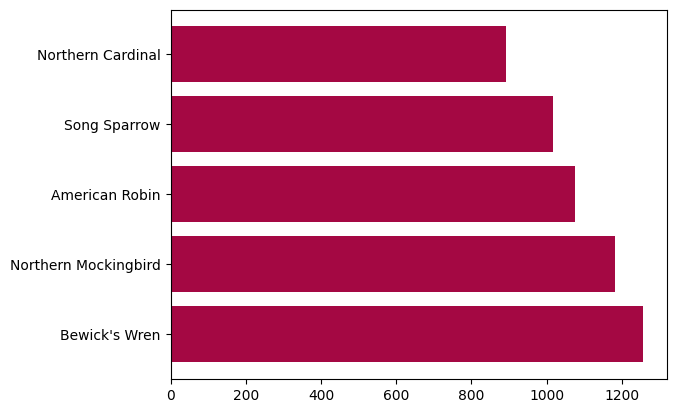

In [7]:
plt.barh(metadata.name.unique(), metadata.name.value_counts(), color=pal.mySpectral()[0]);

In [8]:
# take the 12th to 15th file name
firsts = metadata.groupby('name')['filename'].apply(lambda g: g[12:16])
firsts = firsts.droplevel(level=1)
firsts = dict(firsts)

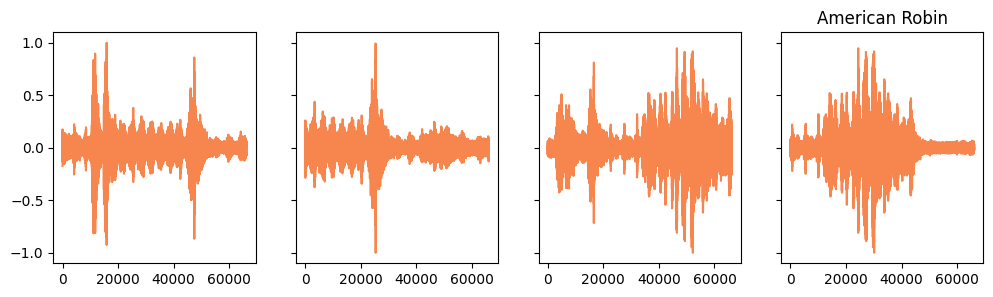

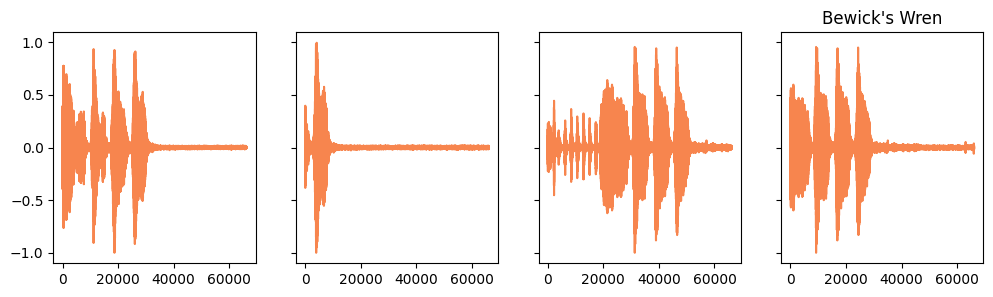

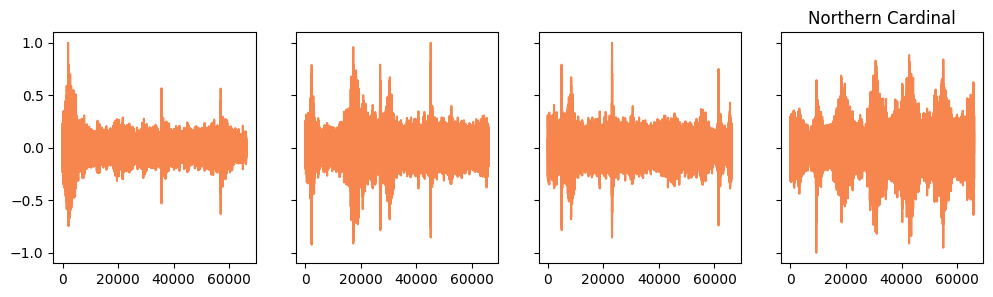

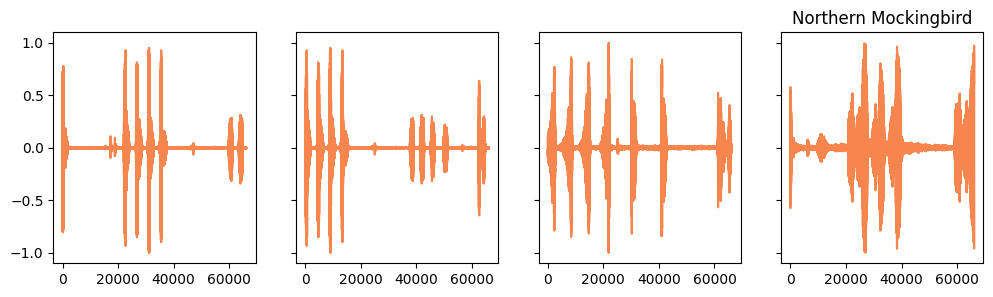

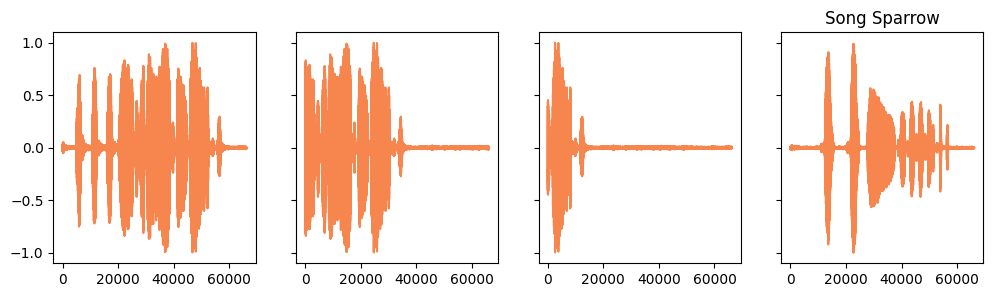

In [9]:
# k is the key represents bird names
# v is the value represents a pandas Series file names
for k,v in firsts.items():
    _, ax = plt.subplots(1, 4, sharey=True, figsize=(12,3))
    for i in range(4):
        fn = f'/kaggle/input/bird-song-data-set/wavfiles/{v.iloc[i]}'
        song, _ = librosa.load(fn)
        ax[i].plot(song, color=pal.mySpectral()[2])
        plt.title(k)
        
del k, v, i, ax

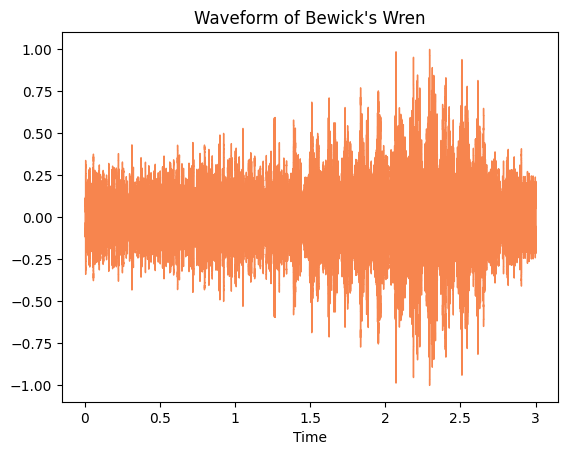

In [10]:
y, sr = librosa.load('/kaggle/input/bird-song-data-set/wavfiles/557838-4.wav')
audio_len = len(y)
librosa.display.waveshow(y, color=pal.mySpectral()[2])
plt.title("Waveform of Bewick's Wren")

IPython.display.Audio('/kaggle/input/bird-song-data-set/wavfiles/557838-4.wav')

# Convert wav file

In [11]:
file_path = metadata.filename.map(lambda a: f'/kaggle/input/bird-song-data-set/wavfiles/{a}')
file_path[0]

'/kaggle/input/bird-song-data-set/wavfiles/557838-0.wav'

In [12]:
data = np.zeros((metadata.shape[0], audio_len))
for i in range(metadata.shape[0]):
    data[i], _ = librosa.load(file_path[i])
data.shape # 2D (total recordings, duration of the recording * sampling rate)

(5422, 66150)

# Create labels

In [13]:
enc = LabelEncoder()
metadata['label'] = enc.fit_transform(metadata.name)
enc.classes_

array(['American Robin', "Bewick's Wren", 'Northern Cardinal',
       'Northern Mockingbird', 'Song Sparrow'], dtype=object)

# MFCC

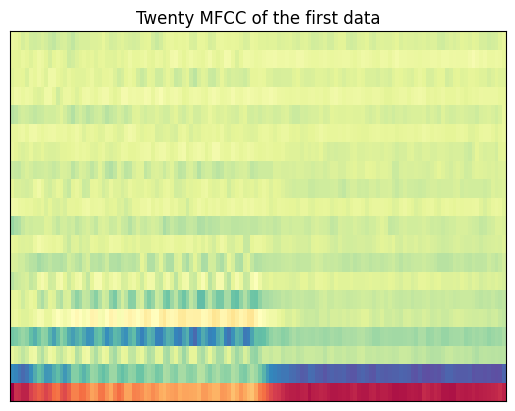

In [14]:
mfcc = librosa.feature.mfcc(y=data[0], sr=sr)
librosa.display.specshow(mfcc, cmap='Spectral')
plt.title(f'Twenty MFCC of the first data');

In [15]:
N_MFCC = 6
SR = sr
mfccs_all = np.zeros((data.shape[0], N_MFCC, mfcc.shape[1]))
for i in range(mfccs_all.shape[0]):
    mfccs_all[i] = librosa.feature.mfcc(y=data[i], sr=SR, n_mfcc=N_MFCC)
mfccs_all.shape

(5422, 6, 130)

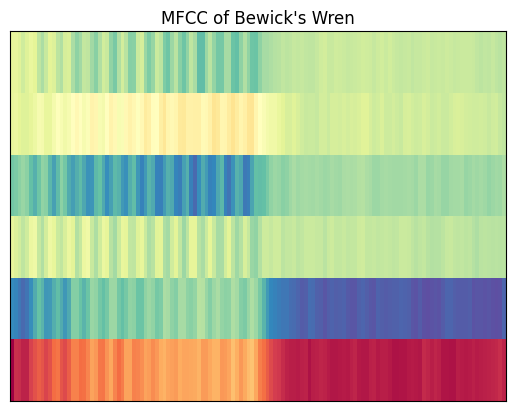

In [16]:
librosa.display.specshow(mfccs_all[0], cmap='Spectral')
plt.title(f'MFCC of {metadata.name.iloc[0]}');

# Split data into train and test

In [17]:
train_X, valid_X, train_y, valid_y = train_test_split(mfccs_all, metadata.label, test_size=0.2, random_state=3)

print(f'train observations: {train_X.shape[0]} and validation observations: {valid_X.shape[0]}')

train observations: 4337 and validation observations: 1085


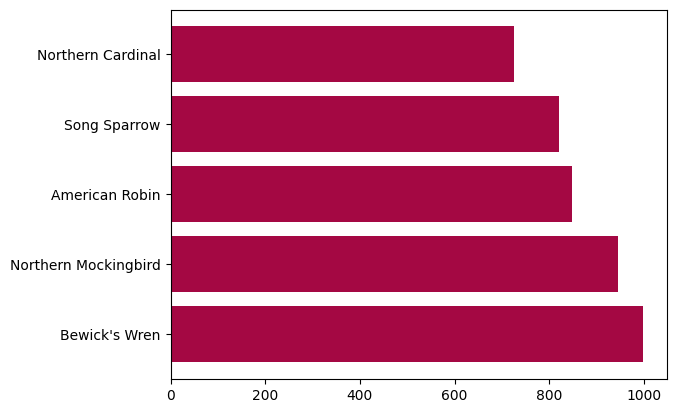

In [18]:
# to ensure the class distribution of the train dataset is similar to that of the original dataset
a = pd.Series(enc.inverse_transform(train_y))
plt.barh(metadata.name.unique(), a.value_counts(), color=pal.mySpectral()[0]);

del a

## ShapeDTW

In [19]:
## the process of Shape DTW for each sequence
## get subsequences from each dimension
subs = MultivariateSubsequenceBuilder(train_X[6].T, subsequence_width=3).transform_time_series_to_subsequences()
subs1 = MultivariateSubsequenceBuilder(train_X[7].T, subsequence_width=3).transform_time_series_to_subsequences()
# subs.subsequences_list[0].subsequences.shape

## put the subsequences into shape descriptors
raw = RawSubsequenceDescriptor()
d = subs.get_shape_descriptors(raw)
d1 = subs1.get_shape_descriptors(raw)

## calculate distances between each shape descriptors. Let's do the dependent version for now
dist_matrix = d.calc_summed_distance_matrix(d1)
# dist_matrix.distance_matrix.shape

## pass the distance matrix to dtw library and compute the distance using DTW
alignment = dtw(dist_matrix.distance_matrix)
alignment.distance

76426.32050824148

In [20]:
dist67 = shape_dtw(train_X[6].T, train_X[7].T, subsequence_width=3, shape_descriptor=raw)
dist67.shape_distance

76426.32050824148

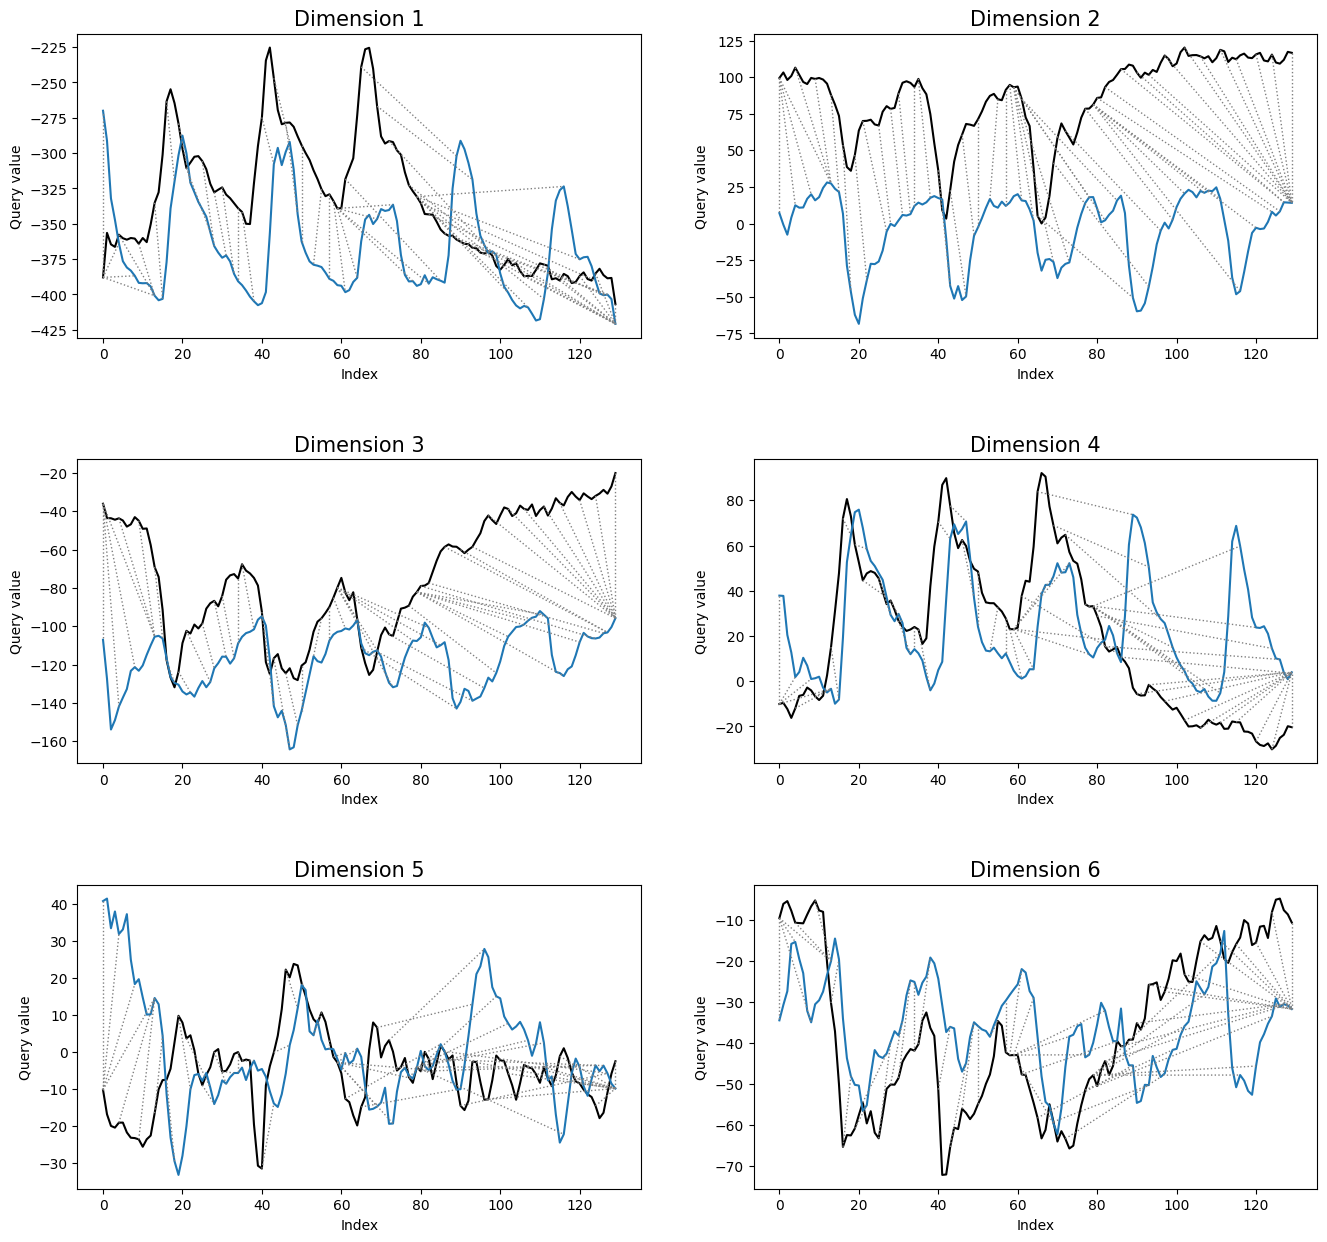

In [21]:
dtwPlot(dist67, plot_type='twoway')

## ShapeDTW for all recordings with parallel computing

In [22]:
raw = RawSubsequenceDescriptor()

def get_subs_shape_desc(row, desc=raw):
    subs = MultivariateSubsequenceBuilder(row.T, subsequence_width=3).transform_time_series_to_subsequences()
    descriptors = subs.get_shape_descriptors(desc)
    return descriptors

def find_NN(newdata, d_):
    distances = []
    ts1 = newdata
    for ts2 in d_:
        dist_mat = ts1.calc_summed_distance_matrix(ts2)
        dist_mat = dist_mat.distance_matrix
        distance = dtw(dist_mat).distance
        distances.append(distance)
    return np.argmin(distances)

In [23]:
# TRAIN data >> subsequences >> shape descriptors
pool = multiprocessing.Pool()
descriptors_t = pool.map_async(get_subs_shape_desc, train_X, chunksize=500)
descriptors_t = list(descriptors_t.get())
pool.close()

In [24]:
# VALID data >> subsequences >> shape descriptors
pool = multiprocessing.Pool()
descriptors_v = pool.map_async(get_subs_shape_desc, valid_X, chunksize=500)
descriptors_v = list(descriptors_v.get())
pool.close()

# KNN

In [25]:
with multiprocessing.Pool(processes=4) as pool:
    closest = pool.map(partial(find_NN, d_=descriptors_t), descriptors_v, chunksize=500)

In [26]:
prediction = train_y.iloc[closest]

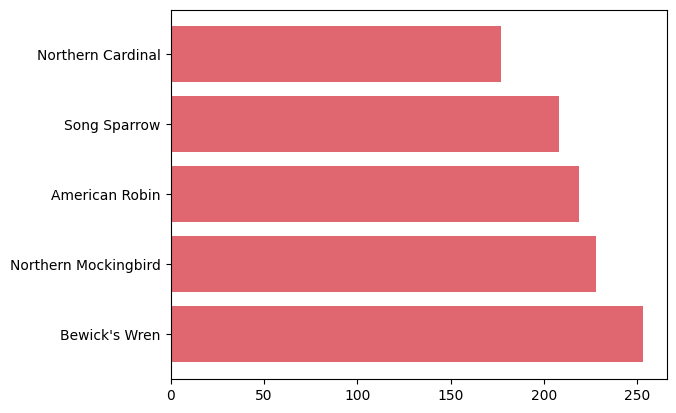

In [27]:
a = pd.Series(enc.inverse_transform(prediction))
plt.barh(metadata.name.unique(), a.value_counts(), color=pal.mySpectral()[1]);

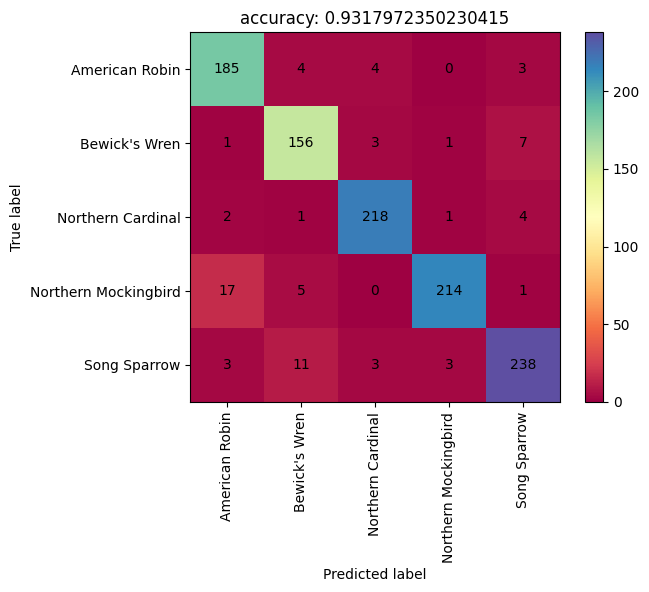

In [28]:
ConfusionMatrixDisplay.from_predictions(valid_y, prediction, display_labels=enc.classes_,
                                        cmap='Spectral', text_kw={'color': 'black'}, xticks_rotation='vertical')
plt.title('accuracy: {}'.format(accuracy_score(valid_y, prediction)));